<a href="https://colab.research.google.com/github/rahul-x-saini/MLFlow/blob/main/MLFlow_With_Data_Logging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install feature_engine

In [2]:
!pip install mlflow

# Import Packages

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.outliers.winsorizer import Winsorizer

import mlflow

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from sklearn.metrics import ConfusionMatrixDisplay

# Load the Data

In [4]:
# read the csv file

df = pd.read_csv("https://raw.githubusercontent.com/Himanshu-1703/mlflow-code-demo/refs/heads/main/data/titanic.csv")

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# check for missing values in data

(
    df
    .isna()
    .sum()
)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Observations :

Age, Emabrked and Cabin columns have missing values.

In [6]:
# info about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Data CLeaning

In [7]:
# columns to drop

columns_to_drop = ['passengerid','name','ticket','cabin']

In [8]:
def clean_data(df):
    return (
        df
        .rename(columns=str.lower)
        .drop(columns=columns_to_drop)
        .assign(
            family = lambda df_ : df_['sibsp'] + df_['parch']
        )
        .drop(columns=['sibsp','parch'])
    )

In [9]:
final_df = clean_data(df)

final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [10]:
# shape of the cleaned data

print(f'The cleaned data has {final_df.shape[0]} rows and {final_df.shape[1]} columns')

The cleaned data has 891 rows and 7 columns


In [11]:
# missing values in the cleaned data

(
    final_df
    .isna()
    .sum()
)

,0
survived,0
pclass,0
sex,0
age,177
fare,0
embarked,2
family,0


# EDA

In [12]:
# distribution of target

(
    final_df
    .loc[:,'survived']
    .value_counts(normalize=True)
)

,proportion
survived,
0,0.616162
1,0.383838


In [13]:
# boxplots

def create_boxplot(data,column_name,hue=None):
    sns.boxplot(data=data, y=column_name, hue=hue)

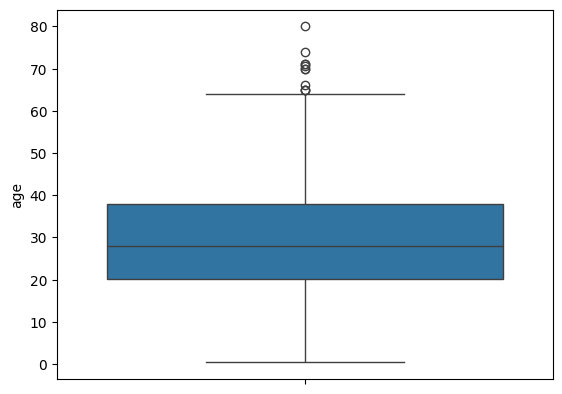

In [14]:
# boxplot for age column
create_boxplot(final_df,'age')

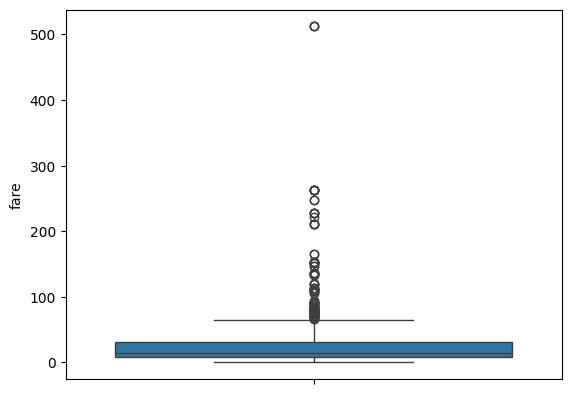

In [15]:
# boxplot for fare column

create_boxplot(final_df,'fare')

Outliers in the age and fare columns

In [16]:
# plot the distribution of categorical columns

def plot_distribution(data,column_name):
    sns.countplot(data=data, x=column_name)

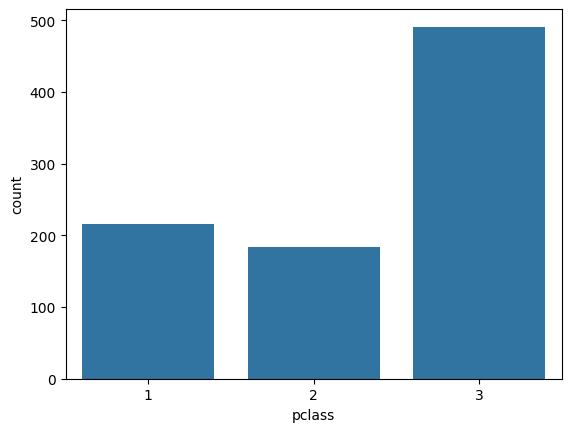

In [17]:
# distribution for pclass
plot_distribution(final_df,'pclass')

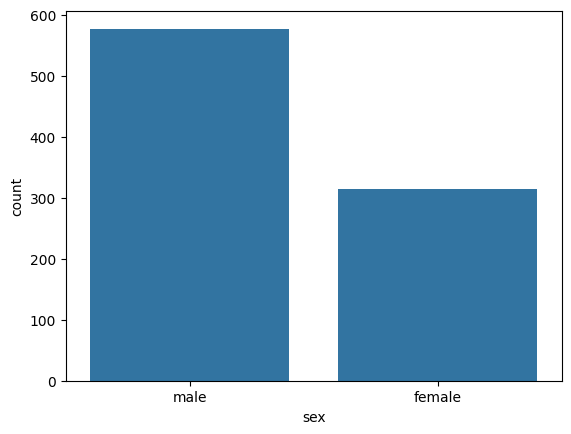

In [18]:
# distribution for sex

plot_distribution(final_df,'sex')

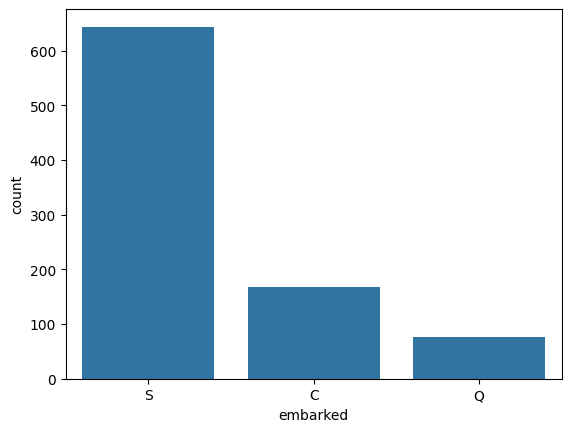

In [19]:
# distribution for embarked

plot_distribution(final_df,'embarked')

# Feature_Engineering

In [20]:
final_df.head()

,survived,pclass,sex,age,fare,embarked,family
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [21]:
# make X and y

X = final_df.drop(columns=['survived'])
y = final_df['survived']

In [22]:
X.head()

,pclass,sex,age,fare,embarked,family
0,3,male,22.0,7.2500,S,1
1,1,female,38.0,71.2833,C,1
2,3,female,26.0,7.9250,S,0
3,1,female,35.0,53.1000,S,1
4,3,male,35.0,8.0500,S,0


In [23]:
# do train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print('The shape of training data is',X_train.shape)
print('The shape of testing data is',X_test.shape)

The shape of training data is (712, 6)
The shape of testing data is (179, 6)


# Pipelines for Individual Columns

In [24]:
# age_pipeline
age_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='median')),
    ('outliers',Winsorizer(capping_method='gaussian',fold=3)),
    ('scale',StandardScaler())
])


age_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())])

In [25]:
# fare pipeline

fare_pipe = Pipeline(steps=[
    ('outliers',Winsorizer(capping_method='iqr',fold=1.5)),
    ('scale',StandardScaler())
])

fare_pipe

Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                ('scale', StandardScaler())])

In [26]:
# embarked_pipeline

embarked_pipe = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('count_encode',CountFrequencyEncoder(encoding_method='count')),
    ('scale',MinMaxScaler())
])

embarked_pipe

Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('count_encode', CountFrequencyEncoder()),
                ('scale', MinMaxScaler())])

# Column Transformer

In [27]:
set_config(transform_output='pandas')

In [28]:
# make column column transformer

preprocessor = ColumnTransformer(transformers=[
    ('age',age_pipe,['age']),
    ('fare',fare_pipe,['fare']),
    ('embarked',embarked_pipe,['embarked']),
    ('sex',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),['sex']),
    ('family',MinMaxScaler(),['family'])
],remainder='passthrough',n_jobs=-1,force_int_remainder_cols=False)

preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('outliers',
                                                  Winsorizer(fold=3)),
                                                 ('scale', StandardScaler())]),
                                 ['age']),
                                ('fare',
                                 Pipeline(steps=[('outliers',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5)),
                                                 ('scale', StandardScaler())]),
                                 ['fare']),
                                ('embarked',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('count_encode',
                                                  CountFrequencyEncoder()),
                                                 ('scale', MinMaxScaler())]),
                                 ['embarked']),
                                ('sex',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex']),
                                ('family', MinMaxScaler(), ['family'])])

In [29]:
# fit and transform the training data

preprocessor.fit_transform(X_train)

,age__age,fare__fare,embarked__embarked,sex__sex_female,sex__sex_male,family__family,remainder__pclass
331,1.266850,0.236751,1.0,0.0,1.0,0.0,1
733,-0.478777,-0.532339,1.0,0.0,1.0,0.0,2
382,0.219474,-0.784153,1.0,0.0,1.0,0.0,3
704,-0.246027,-0.787666,1.0,0.0,1.0,0.1,3
813,-1.797695,0.374443,1.0,1.0,0.0,0.6,3
...,...,...,...,...,...,...,...
106,-0.633944,-0.797799,1.0,1.0,0.0,0.0,3
270,-0.090860,0.360798,1.0,0.0,1.0,0.0,1
860,0.917724,-0.477346,1.0,0.0,1.0,0.2,3
435,-1.177028,2.016201,1.0,1.0,0.0,0.3,1


In [30]:
preprocessor.get_params()

{'force_int_remainder_cols': False,
 'n_jobs': -1,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('age',
   Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                   ('outliers', Winsorizer(fold=3)), ('scale', StandardScaler())]),
   ['age']),
  ('fare',
   Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                   ('scale', StandardScaler())]),
   ['fare']),
  ('embarked',
   Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                   ('count_encode', CountFrequencyEncoder()),
                   ('scale', MinMaxScaler())]),
   ['embarked']),
  ('sex',
   OneHotEncoder(handle_unknown='ignore', sparse_output=False),
   ['sex']),
  ('family', MinMaxScaler(), ['family'])],
 'verbose': False,
 'verbose_feature_names_out': True,
 'age': Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                 ('outliers', Winsorizer(fold=3)), ('s

# Model Pipeline

In [31]:
# build the model pipeline

model_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 0.8,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}

In [32]:
model_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('clf',RandomForestClassifier(**model_params))
])

model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('sca...
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf',
                 RandomForestClassifier(max_depth=6, max_samples=0.8,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=30))])

In [33]:
# fit the model on the training data

model_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('age',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   Winsorizer(fold=3)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('fare',
                                                  Pipeline(steps=[('outliers',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5)),
                                                                  ('sca...
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('count_encode',
                                                                   CountFrequencyEncoder()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['embarked']),
                                                 ('sex',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('family', MinMaxScaler(),
                                                  ['family'])])),
                ('clf',
                 RandomForestClassifier(max_depth=6, max_samples=0.8,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=30))])

In [34]:
# evaluate the model on the test data

y_pred = model_pipe.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

In [35]:
# metrics dict

metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

metrics

{'accuracy': 0.8156424581005587,
 'precision': 0.8253968253968254,
 'recall': 0.7027027027027027,
 'f1_score': 0.7591240875912408}

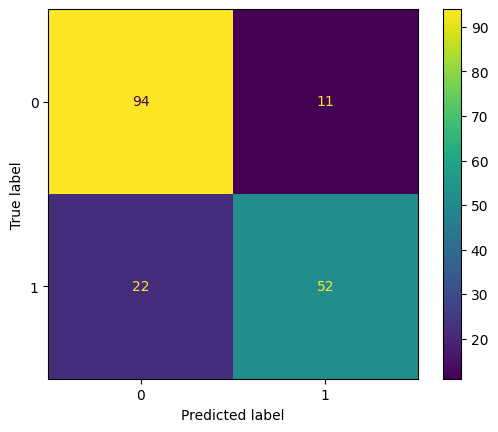

In [36]:
# plot confusion matrix

cm = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

# MLFlow Tracking code

In [37]:
model_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                     remainder='passthrough',
                     transformers=[('age',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='median')),
                                                    ('outliers',
                                                     Winsorizer(fold=3)),
                                                    ('scale', StandardScaler())]),
                                    ['age']),
                                   ('fare',
                                    Pipeline(steps=[('outliers',
                                                     Winsorizer(capping_method='iqr',
                                                                fold=1.5)),
                                                    ('scale', StandardScaler())]),
                             

In [38]:
X_test.join(y_test)

,pclass,sex,age,fare,embarked,family,survived
709,3,male,NaN,15.2458,C,2,1
439,2,male,31.0,10.5000,S,0,0
840,3,male,20.0,7.9250,S,0,0
720,2,female,6.0,33.0000,S,1,1
39,3,female,14.0,11.2417,C,1,1
...,...,...,...,...,...,...,...
433,3,male,17.0,7.1250,S,0,0
773,3,male,NaN,7.2250,C,0,0
25,3,female,38.0,31.3875,S,6,1
84,2,female,17.0,10.5000,S,0,1


In [39]:
# check if uri is set

mlflow.is_tracking_uri_set()

False

In [42]:
# set the uri for server

mlflow.set_tracking_uri("sqlite:///mlflow.db")

mlflow.set_experiment("Mentos Zindagi")

with mlflow.start_run() as run:
    # log the data signature
    data_signature = mlflow.models.infer_signature(model_input=X_train,model_output=model_pipe.predict(X_train))

    # log preprocessor parameters
    mlflow.log_params(model_pipe.get_params())

    # log model metrics
    mlflow.log_metrics(metrics)

    # log the model
    mlflow.sklearn.log_model(sk_model=model_pipe,
                             name="Model",
                             signature=data_signature,)


    # Get the model uri
    model_uri = mlflow.get_artifact_uri("Model")

    # # evaluate the model
    # evaluations = mlflow.models.evaluate(model=model_uri,
    #                        data=X_test.join(y_test),
    #                        targets='survived',
    #                        model_type="classifier")

    # log the confusion matrix
    mlflow.log_figure(cm.figure_,artifact_file='confusion_matrix.png')

    # create mlflow data
    data = mlflow.data.from_pandas(df=X_train,name='training')

    # log the input
    mlflow.log_input(dataset=data,context='training')

/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, wh